In [1]:
# Declare whether you are on Colab or local
colab = True

In [2]:
if colab==True:
  
  #Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  #set path to data in Google Drive
  data_path = "/content/drive/MyDrive/2022_Analytics Lab Student Projects/Data/All Topics"

  #install required packages
  !pip install duckdb
  !pip install -U sentence-transformers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#!pip install -U sentence-transformers

In [4]:
# Import sentence_transformers 
from sentence_transformers import SentenceTransformer, util

In [5]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import sqlalchemy
#%load_ext sql

In [6]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

**Task: Automated Ontology Refinement with Sentence Similarity**
<br>
- Task
  - Identification of new entity candidates
  - Semi-automatic procedure for enhancing the ontology
- Learning
  - SentenceBERT (pretrained)
    - Fine-tuning with ontology
    - Pairs of phrases, e.g. entities and synonyms
    - Identification of candidate entities (noun phrases?)
- Input
  - entities.csv
  - sentences.csv


# Test iteration over sample article and find similarities between ontology and sentences in article 

## Load data

### `sentences.csv`

In [7]:
# Load sentences
if colab==True:
  sentences = pd.read_csv(data_path+"/Fulltext of Corpus/sentences.csv")
else:
  sentences = pd.read_csv("../Data/FulltextofCorpus/sentences.csv")

In [8]:
# Assess shape of sentences.csv
sentences.shape

(6563319, 10)

In [9]:
# Subset only first article
sample_article_df = sentences.loc[sentences.article_id==1]
sample_article_df.shape

(1013, 10)

In [10]:
# delete sentences from RAM
del sentences 

In [11]:
sample_article_df.head()

,article_id,sentence_id,para_id,sentence,section_nr,last_section_title,last_subsection_title,sentence_type,references,number_of_citations
0,1,1_0_1,1_0,,0,NaN,NaN,EMPTY,[],0
1,1,1_1_2,1_0,START_TITLE_TAG,0,NaN,NaN,TAG,[],0
2,1,1_2_22,1_0,Examining interdependence between product user...,0,NaN,NaN,PARAGRAPH,[],0
3,1,1_22_23,1_1,START_ABSTRACT_TAG,0,NaN,NaN,TAG,[],0
4,1,1_23_24,1_1,,0,Abstract,NaN,EMPTY,[],0


In [12]:
# Check values in colums of interest
sample_article_df.sentence_type.value_counts()

PARAGRAPH        357
TAG              279
EMPTY            146
TABLE            135
HEADER            24
CAPTION           22
FORMULA           17
ABSTRACT          11
ANNEX             11
TABLE_HEADER       6
FIGURE_HEADER      2
HYP_NUMBER         1
HYPOTHESIS         1
FIGURE             1
Name: sentence_type, dtype: int64

### `isrecon.duckdb`

In [13]:
# Note that DBeaver must be closed, before you can run this command!
if colab==True:
  con = duckdb.connect(database=data_path+'/Extracted Information of Corpus/isrecon.duckdb', read_only=False)
else:
  con = duckdb.connect(database='../Data/ExtractedInformationofCorpus/isrecon.duckdb', read_only=False)

In [14]:
# Load first article as df
entities_sample_article = entities = con.execute("""
                       SELECT *
                       FROM entities e
                       WHERE e.article_id = 1""").fetchdf()

entities_sample_article.shape

(132, 46)

In [15]:
entities_sample_article.ent_id.nunique()

46

In the first article 
- Total of 132 entities have been found
- 46 unique entities have been found

In [16]:
entities_sample_article.head()

,article_id,para_id,sentence_start,sentence_id,section_title,subsection_title,label,ent_id,level_1,level_2,...,attr_double,attr_stage,attr_type,attr_temporal,attr_assumption,attr_dsr,attr_paired,attr_setting,attr_level,attr_tool
0,1,1_3,322,1_322_354,Introduction,NaN,TOPIC,knowledge repository,domain specific entity,IS topic,...,0,0,0,0,0,0,0,0,0,0
1,1,1_3,467,1_467_502,Introduction,NaN,TOPIC,digital platform,domain specific entity,IS topic,...,0,0,0,0,0,0,0,0,0,0
2,1,1_3,502,1_502_527,Introduction,NaN,TECHNOLOGY,Salesforce.com,domain specific entity,IS technology,...,0,0,0,0,0,0,0,0,0,0
3,1,1_4,530,1_530_551,Introduction,NaN,TOPIC,participatory design,domain specific entity,IS topic,...,0,0,0,0,0,0,0,0,0,0
4,1,1_5,861,1_861_886,Introduction,NaN,PARTICIPANTS,group participant,domain specific entity,study object,...,0,0,0,0,0,0,0,0,1,0


In [17]:
#Check columns and datatypes
entities_sample_article.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   article_id        132 non-null    int64  
 1   para_id           132 non-null    object 
 2   sentence_start    132 non-null    int64  
 3   sentence_id       132 non-null    object 
 4   section_title     120 non-null    object 
 5   subsection_title  0 non-null      object 
 6   label             132 non-null    object 
 7   ent_id            132 non-null    object 
 8   level_1           132 non-null    object 
 9   level_2           132 non-null    object 
 10  level_3           130 non-null    object 
 11  level_4           118 non-null    object 
 12  level_5           66 non-null     object 
 13  level_6           19 non-null     object 
 14  level_7           6 non-null      object 
 15  level_8           3 non-null      object 
 16  level_9           2 non-null      object 
 1

- It needs to be clarified, which of these columns are relevant for the task (assumption only first ~17 are somehow relevant for us)
- Which columns do we need for the training (probably only sentence_id, entity_id, synoyms)? 

In [18]:
# Check which sentences have more than one label 
entities_sample_article[entities_sample_article['sentence_id']\
                        .map(entities_sample_article['sentence_id'].value_counts()) > 1]

,article_id,para_id,sentence_start,sentence_id,section_title,subsection_title,label,ent_id,level_1,level_2,...,attr_double,attr_stage,attr_type,attr_temporal,attr_assumption,attr_dsr,attr_paired,attr_setting,attr_level,attr_tool
11,1,1_12,1410,1_1410_1433,Firm-hosted online branding communities,NaN,MODEL_ELEMENT,research hypothesis,theoretical entity,model,...,0,0,0,0,0,0,0,0,0,0
12,1,1_12,1410,1_1410_1433,Firm-hosted online branding communities,NaN,THEORY,social exchange theory,theoretical entity,theory,...,0,0,0,0,0,0,0,0,0,0
14,1,1_12,1455,1_1455_1476,Firm-hosted online branding communities,NaN,PARTICIPANTS,group participant,domain specific entity,study object,...,0,0,0,0,0,0,0,0,1,0
15,1,1_12,1455,1_1455_1476,Firm-hosted online branding communities,NaN,PARTICIPANTS,individual participant,domain specific entity,study object,...,0,0,0,0,0,0,0,0,1,0
16,1,1_12,1476,1_1476_1498,Firm-hosted online branding communities,NaN,PARTICIPANTS,individual participant,domain specific entity,study object,...,0,0,0,0,0,0,0,0,1,0
17,1,1_12,1476,1_1476_1498,Firm-hosted online branding communities,NaN,PARTICIPANTS,individual participant,domain specific entity,study object,...,0,0,0,0,0,0,0,0,1,0
19,1,1_19,2348,1_2348_2387,Social exchange theory and knowledge contribut...,NaN,THEORY,social exchange theory,theoretical entity,theory,...,0,0,0,0,0,0,0,0,0,0
20,1,1_19,2348,1_2348_2387,Social exchange theory and knowledge contribut...,NaN,THEORY,social exchange theory,theoretical entity,theory,...,0,0,0,0,0,0,0,0,0,0
23,1,1_19,2502,1_2502_2568,Social exchange theory and knowledge contribut...,NaN,TECHNOLOGY,online community,domain specific entity,IS technology,...,0,0,0,0,0,0,0,0,0,0
24,1,1_19,2502,1_2502_2568,Social exchange theory and knowledge contribut...,NaN,TOPIC,open source,domain specific entity,IS topic,...,0,0,0,0,0,0,0,0,0,0


Each sentence in entities can have more than one entities -> this will lead to an increase in rows when merged to sentences.csv

### `isntology.csv`

In [19]:
# Load ontology
if colab==True:
  ontology_syn = pd.read_csv(data_path+"/Synonyms in Ontology/isontology.csv", index_col=0)
else:
  ontology_syn = pd.read_csv("../Data/SynonymsinOntology/isontology.csv", index_col=0)
ontology_syn.shape

(390838, 4)

In [20]:
#Display head
ontology_syn.head()

,entity_id,category,label,synonym
0,IS topic,domain specific entity,TOPIC,is topics
1,IS topic,domain specific entity,TOPIC,is topic
2,IS sourcing,domain specific entity,TOPIC,information and communications technologies so...
3,IS sourcing,domain specific entity,TOPIC,it sourcing
4,IS sourcing,domain specific entity,TOPIC,information communications technology sourcing


In [21]:
# Check different values for "label" column
ontology_syn.label.value_counts()

PARTICIPANTS         235200
COLLECTION_METHOD     60176
TECHNOLOGY            39336
TOPIC                 22599
VALIDITY              16874
ANALYSIS_METHOD        4051
CONCEPTUAL_METHOD      3219
SECTOR                 2869
METRIC                 2728
MODEL_ELEMENT          1302
THEORY                 1188
COMPANY_TYPE            550
SAMPLING                372
PARADIGM                330
LEVEL                    44
Name: label, dtype: int64

- Looking at the ontology in protege, it is not clear for me what exactly the label column contains and how it is related to the hierarchy of the ontology. 
- My guess is that it is the first level of the ontology, but it seems that the words in the .csv slightly differ from the ones in protege or .json (e.g. json: "research paradigm" but in isontology.csv: "PARADIGM"

In [22]:
# Check different values for "category" column
ontology_syn.category.value_counts()

study object              235750
domain specific entity     64804
research method            63395
methodological entity      24025
theoretical entity          2864
Name: category, dtype: int64

- The column `category` seem to contain the "level 0" of the ontology 
- However this level 0 does no texist in the json file and in protege the five different categories are distributed over the 1st & 2nd level ? (Only domain specific entity, methodological entity, theoretical entity are in 1st level of protege file)

In [23]:
# Check number of synonyms per entity_id
ent_sy_group = ontology_syn.groupby("entity_id")[["synonym"]].nunique().sort_values(by="synonym", ascending=False)

In [24]:
ent_sy_group

,synonym
entity_id,
individual participant,220966
survey,42098
three validities,16002
online learning system,10075
communication service infrastructure,8932
...,...
generative adversarial network,2
mutual information,1
World of Warcraft,1


For each of the 2689 unique entities there is one/many synonym(s)

In [25]:
# Check how many entities have more than 100 synonyms
ent_sy_group[ent_sy_group["synonym"]>100]

,synonym
entity_id,
individual participant,220966
survey,42098
three validities,16002
online learning system,10075
communication service infrastructure,8932
...,...
system integration,101
systems documentation,101
IS effectiveness,101


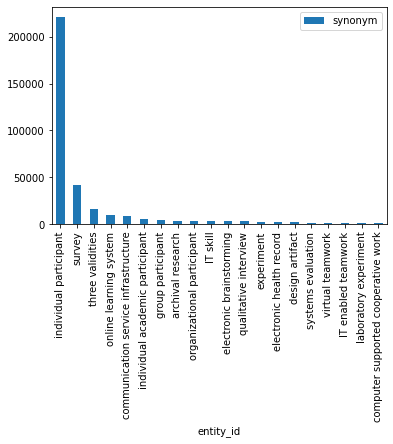

In [26]:
# Plot top 20 entities with most synonyms
ent_sy_group.head(20).plot(kind="bar");

- Apparently there are 220_966 synoyms for individual participant
- 131 entities have more than 100 synonyms. In order to limit the number of possible similarities, we will downsample these 131 entities to 100

In [27]:
# Downsample entities with more than 100 synonyms to a 100 synoyms
idx = ent_sy_group[ent_sy_group["synonym"]>100].index.tolist()

dfs = []
for entity in idx:
  dfs.append((ontology_syn.loc[ontology_syn["entity_id"]==entity]).sample(100))
dfs.append(ontology_syn.loc[~ontology_syn["entity_id"].isin(idx)])

In [28]:
ontology_syn_ds = pd.concat(dfs).reset_index(drop=True)

In [29]:
print("Before downsampling:",ontology_syn.shape[0])
print("After downsampling:",ontology_syn_ds.shape[0])

Before downsampling: 390838
After downsampling: 36158


## Load pretrained Sentence-BERT

In [36]:
# Load a pre-trained model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

### Test SBERT & Create functions for similarity comparison (taken from `MiningRelationships.ipynb`)

In [37]:
# Use the model to find pair similarities
def find_similarity(model, term1, term2):

    # Compute embedding for both lists
    embeddings1 = model.encode([term1], convert_to_tensor=True)
    embeddings2 = model.encode([term2], convert_to_tensor=True)

    # Compute cosine-similarits
    cosine_score = util.pytorch_cos_sim(embeddings1, embeddings2).item()

    print(cosine_score)

In [38]:
find_similarity(model,"software developer", "software engineer")
find_similarity(model,"database designer", "data architect")
find_similarity(model,"welder", "solderer")

0.8729228973388672
0.6365392804145813
0.32684826850891113


In [39]:
def find_top_similar(model, terms, k=10):
    '''
    Use the model to find similar pairs (compare all sentences against all other sentences)
    Returns a list with the pairs that have the highest cosine similarity score -> [score, idx_sentence1, idx_sentence2]     
    '''
    # Compute highest cosine similarity score
    paraphrases = util.paraphrase_mining(model, terms, show_progress_bar = True, top_k=k)
    
    # Store result in df & add sentences as text
    tmp_df = pd.DataFrame(paraphrases, columns=["cos_sim_score", "idx_sent1", "idx_sent2"])
    tmp_df[["txt_sent1", "txt_sent2"]] = tmp_df[["idx_sent1", "idx_sent2"]].applymap(lambda x:  terms[x])
    
    return tmp_df

In [40]:
find_top_similar(model, ["data science", "data engineer", "welding", "soldering"], 1)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,cos_sim_score,idx_sent1,idx_sent2,txt_sent1,txt_sent2
0,0.684672,0,1,data science,data engineer
1,0.552656,2,3,welding,soldering


### Find similarities between different sentences in sample article 

In [41]:
# Remove empty and tag sentences from article
sample_article_df_clean = sample_article_df.loc[~sample_article_df.sentence_type.isin(["EMPTY", "TAG"])]

In [42]:
all_sentences = sample_article_df_clean.sentence.tolist()

In [43]:
# Find similar sentences within smaple article
sim_sentences = find_top_similar(model, all_sentences, 2)

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

In [44]:
sim_sentences

,cos_sim_score,idx_sent1,idx_sent2,txt_sent1,txt_sent2
0,1.000000,456,498,Max \n,Max \n
1,1.000000,233,240,Online profile data of the product user,Online profile data of the product user
2,1.000000,291,410,1,1
3,1.000000,291,420,1,1
4,1.000000,410,420,1,1
...,...,...,...,...,...
890,0.297382,587,558,Weifei,Hausman \n8117
891,0.290877,573,151,Finding \nDholakia et al. \n \n \n \n,"(e.g., START_CITE Singh et al., 2014; END_CIT..."
892,0.263152,395,288,Wiertz and De,exp(γ'Zi (t-1)) 1 + exp(γ'Zi (t-1))
893,0.260414,389,385,Jeppesen and,"Baron (2007, 2009)"


- There are a lot of identical sentences in the article. 
- However, since our task is not to compare similarity between sentences we ignore this for now
- It might be useful to drop duplicate sentences and maybe preprocess sentences before training/ similarity comparison?

### Find similarities between ontology (without synonyms) and sentences in sample article 

In [45]:
#List of unique entities from ontology (first without synonyms)
entities_unique = ontology_syn.entity_id.unique().tolist()

In [92]:
def find_similarity_sent_ent(sentences, entities):
  '''Compute cosine similarity between sentences and entities. Returns dataframe with score, idx & text of entities and sentences'''

  #Compute embeddings
  embeddings_sentences = model.encode(sentences, convert_to_tensor=True)
  embeddings_entities = model.encode(entities, convert_to_tensor=True)

  #Compute cosine-similarities for each sentence with each other entity
  cosine_scores = util.cos_sim(embeddings_sentences, embeddings_entities)
  cosine_scores = cosine_scores.cpu().detach().numpy() #convert to numpy

  # Get shape of cosine scores for indexing sentences and entities
  no_rows = cosine_scores.shape[0]
  no_cols = cosine_scores.shape[1]
  
  # Create array representing indices of the cosine_scores grid for indexing sentences and entities
  row, col = np.indices((no_rows, no_cols))

  # Reshape cosine_score, row and col so that there is one row per comparison (similarity between one sentence and one entity)
  cosine_scores = cosine_scores.reshape(no_rows*no_cols,1)
  row = row.reshape(no_rows*no_cols,1)
  col = col.reshape(no_rows*no_cols,1)

  #Stack arrays
  array_tmp = np.hstack((cosine_scores, row, col))

  # Convert to df and recreate text & Sort scores in decreasing order
  pairs_df = pd.DataFrame(array_tmp, columns=['score', 'idx_sentence', 'idx_entity']).sort_values(by="score", ascending=False)
  pairs_df[['idx_sentence', 'idx_entity']] = pairs_df[['idx_sentence', 'idx_entity']].astype("int")
  pairs_df[["txt_sent"]] = pairs_df[["idx_sentence"]].applymap(lambda x:  sentences[x])
  pairs_df[["txt_ent"]] = pairs_df[["idx_entity"]].applymap(lambda x:  entities[x])
  pairs_df = pairs_df.reset_index(drop=True)

  return pairs_df

In [93]:
# Compute similarity between sentences and entities
pairs_df = find_similarity_sent_ent(all_sentences, entities_unique)

☝ Already takes 30 sec and may become problematic when we want to iterate over all articles or include synonyms

In [94]:
# Show dataframe
pairs_df.head()

,score,idx_sentence,idx_entity,txt_sent,txt_ent
0,1.000000,494,498,Variable \n,variable
1,1.000000,452,498,Variable \n,variable
2,1.000000,571,517,Research Question \n,research question
3,0.926662,320,498,Variables,variable
4,0.890720,411,2342,Conceptual Model.,conceptual modelling


In [95]:
#pd.set_option('display.max_colwidth', None)

In [96]:
# Drop duplicate sentences 
pairs_df = pairs_df.drop_duplicates(subset=["txt_sent", "txt_ent"])

In [97]:
# Filter for scores >0.65
pairs_df[pairs_df.score>0.65].shape
pairs_df[pairs_df.score>0.65].head(10)

,score,idx_sentence,idx_entity,txt_sent,txt_ent
0,1.000000,494,498,Variable \n,variable
2,1.000000,571,517,Research Question \n,research question
3,0.926662,320,498,Variables,variable
4,0.890720,411,2342,Conceptual Model.,conceptual modelling
5,0.853788,112,1018,"This, as indicated by social exchange theory (...",social exchange theory
6,0.816762,411,2282,Conceptual Model.,conceptual analysis
7,0.800409,411,2221,Conceptual Model.,conceptual method
8,0.782838,571,513,Research Question \n,research hypothesis
9,0.778290,59,2222,Literature review,literature study
10,0.757772,82,1018,Social exchange theory is based on the univers...,social exchange theory


### Find similarities between ontology (with synonyms) and sentences in sample article 

In [98]:
#List of unique entities from ontology with synonyms without downsampling
entities_syn_unique = ontology_syn.synonym.unique().tolist()

In [99]:
#List of unique entities from ontology with synonyms with downsampling
entities_syn_unique_ds = ontology_syn_ds.synonym.unique().tolist()

In [100]:
print("Number of unique entities wo synonyms:", len(entities_unique))
print("Number of unique entities with synonyms without downsampling:", len(entities_syn_unique))
print("Number of unique entities with synonyms with downsampling:", len(entities_syn_unique_ds))

Number of unique entities wo synonyms: 2689
Number of unique entities with synonyms without downsampling: 390100
Number of unique entities with synonyms with downsampling: 35974


In [101]:
# Compute similarity between sentences and entities with syn with downsampling
pairs_syn_ds_df = find_similarity_sent_ent(all_sentences, entities_syn_unique_ds)

In [ ]:
# Compute similarity between sentences and entities with syn without downsampling
#pairs_syn_df = find_similarity_sent_ent(all_sentences, entities_syn_unique)

- ☝ Runnning this code in Colab on entities with with downsampled synonyms takes ~ 1:30 min 
- Running the code without downsampling is not possible because of **RAM overload**
- There is also the function `paraphrase_mining`, which improves the brute force comparison, but this only works for one list (sentences or entities or both) --> Need to clarify how to avoid comparison between sentences or comparison between entities?

In [102]:
pairs_syn_ds_df.head()
pairs_syn_ds_df.shape

,score,idx_sentence,idx_entity,txt_sent,txt_ent
24350,0.531986,43,56,Autonomous online communities that are independent of any particular firm but are dedicated to the support of one or more companies' products,internet sourcings
30127,0.514160,53,448,"We then investigate the hypotheses using data from the OUC of BMC, a global leader in producing innovative software solutions.",onshore softwares
18489,0.512423,32,234,"Over time, host firm employees and product users may get to know each other more personally, communicating and coordinating with each other offline.",offshoring of? internet
18556,0.510063,32,301,"Over time, host firm employees and product users may get to know each other more personally, communicating and coordinating with each other offline.",internet offshoring
18568,0.499823,32,313,"Over time, host firm employees and product users may get to know each other more personally, communicating and coordinating with each other offline.",internet offshorings
...,...,...,...,...,...
114803,-0.155094,247,443,The dependent variable of employee content generation was entered for each author-month pair by counting the number of new documents the author posted in the next month.,is / it onshore
114785,-0.155094,247,425,The dependent variable of employee content generation was entered for each author-month pair by counting the number of new documents the author posted in the next month.,is/it onshore
83046,-0.157819,164,309,"Community profiles include employees' demographic data, network data (e.g., following/followers), participation data (e.g., discussion and document contributions), and reputation data (e.g., points and levels).",offshore is
114806,-0.171153,247,446,The dependent variable of employee content generation was entered for each author-month pair by counting the number of new documents the author posted in the next month.,is / it onshores


## Merge tables

In [30]:
# Merge sentences from first article with entities
sample_art_ent = sample_article_df.\
    merge(entities_sample_article[["sentence_id", "ent_id"]], how="left", on="sentence_id")

In [31]:
# Compare snumber of rows from sentences with merged df
sample_art_ent.shape[0]-sample_article_df.shape[0]

21

There are 21 "new" rows, since one sentence can have multiple entities

In [32]:
# Show some sentences with multiple entities
sample_art_ent[sample_art_ent['sentence_id'].map(sample_art_ent['sentence_id'].value_counts()) > 1].head()

,article_id,sentence_id,para_id,sentence,section_nr,last_section_title,last_subsection_title,sentence_type,references,number_of_citations,ent_id
89,1,1_1410_1433,1_12,We next review extant studies on OUC and devel...,2,Firm-hosted online branding communities,NaN,PARAGRAPH,[],0,research hypothesis
90,1,1_1410_1433,1_12,We next review extant studies on OUC and devel...,2,Firm-hosted online branding communities,NaN,PARAGRAPH,[],0,social exchange theory
92,1,1_1455_1476,1_12,We collected a total of 815 community document...,2,Firm-hosted online branding communities,NaN,PARAGRAPH,[],0,group participant
93,1,1_1455_1476,1_12,We collected a total of 815 community document...,2,Firm-hosted online branding communities,NaN,PARAGRAPH,[],0,individual participant
94,1,1_1476_1498,1_12,"In addition, a total of 12,315 product users w...",2,Firm-hosted online branding communities,NaN,PARAGRAPH,[],0,individual participant


In [33]:
# Left Join synonyms on merged_df
sample_art_ent_syn = sample_art_ent.merge(ontology_syn, how="left", left_on="ent_id", right_on="entity_id")

In [34]:
# Check shape 
sample_art_ent_syn.shape

(1581937, 15)

In [35]:
# Show number of synonyms/ rows per sentence & entity
sample_art_ent_syn.groupby(["sentence_id", "entity_id"])[["synonym"]].nunique()\
    .sort_values(by="synonym", ascending=False)

,,synonym
sentence_id,entity_id,
1_1455_1476,individual participant,220966
1_4457_4496,individual participant,220966
1_5045_5074,individual participant,220966
1_5074_5085,individual participant,220966
1_2641_2667,individual participant,220966
...,...,...
1_3835_3866,blog,2
1_4425_4457,competitive advantage,2
1_10695_10701,Salesforce.com,2


The shape of the dataframe increased dramatically, because some entities have a high number of synonyms and thus "blow" up the dataframe

In [36]:
# Remove empty and tag sentences
sample_art_ent_syn_clean = sample_art_ent_syn.loc[~sample_art_ent_syn.sentence_type.isin(["EMPTY", "TAG"])]